In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder

import math
import os
import re
import gc
import urllib.request
import zipfile
import copy
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
#Augmentation 함수 설계
#========================================================================================================================================================#
def get_clip_box(image_a, image_b):
    # image.shape = (channel, height, width)
    image_size_x = image_a.shape[1]  # Width
    image_size_y = image_a.shape[0]  # Height

    # Get center of box
    x = torch.randint(0, image_size_x, (1,)).item()
    y = torch.randint(0, image_size_y, (1,)).item()

    width = max(1, int(image_size_x * torch.sqrt(1 - torch.rand(1)).item()))
    height = max(1, int(image_size_y * torch.sqrt(1 - torch.rand(1)).item()))

    # Clip box in image and get minmax bbox
    x_min = max(0, x - width // 2)
    y_min = max(0, y - height // 2)
    x_max = min(image_size_x, x + width // 2 + 1)
    y_max = min(image_size_y, y + height // 2 + 1)

    return x_min, y_min, x_max, y_max


def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    # image.shape = (C, H, W)
    image_size_x = image_a.shape[1]  # Width
    image_size_y = image_a.shape[0]  # Height

    if isinstance(image_a, np.ndarray):
        image_a = torch.from_numpy(image_a).to(device)
    if isinstance(image_b, np.ndarray):
        image_b = torch.from_numpy(image_b).to(device)

    top = image_a[:y_min, : , :]
    middle_left = image_a[y_min:y_max, :x_min , :]
    middle_center = image_b[y_min:y_max, x_min:x_max , :]
    middle_right = image_a[y_min:y_max, x_max:, :]
    bottom = image_a[y_max:, : , :]

    top = top.to(device)
    middle_left = middle_left.to(device)
    middle_center = middle_center.to(device)
    middle_right = middle_right.to(device)
    bottom = bottom.to(device)

    # 중간 부분(왼쪽, 중앙, 오른쪽) 결합
    middle = torch.cat([middle_left, middle_center, middle_right], dim=1)

    # 전체 이미지 결합 (위 + 중간 + 아래)
    mixed_img = torch.cat([top, middle, bottom], dim=0)

    return mixed_img

# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]  # Width
    image_size_y = image_a.shape[0]  # Height

    # 바운딩 박스 비율 계산
    mixed_area = (x_max - x_min) * (y_max - y_min)
    total_area = image_size_x * image_size_y
    ratio = mixed_area / total_area

     # 원-핫 벡터 변환
    if label_a.dim() == 0:
        label_a = F.one_hot(label_a, num_classes=num_classes).float()
    if label_b.dim() == 0:
        label_b = F.one_hot(label_b, num_classes=num_classes).float()

    # 비율에 따라 라벨 혼합
    mixed_label = (1 - ratio) * label_a + ratio * label_b
    return mixed_label

def cutmix(images, labels, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(min(batch_size,len(images))):
        image_a = images[i]
        label_a = labels[i]

        j = torch.randint(0, min(batch_size,len(images)), (1,)).item()  # 다른 샘플 선택
        image_b = images[j]
        label_b = labels[j]

        # 바운딩 박스 생성
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

        # 이미지 섞기
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes))

    # 텐서 변환
    mixed_imgs = torch.stack(mixed_imgs)
    mixed_labels = torch.stack(mixed_labels).reshape(min(batch_size,len(images)), num_classes)

    return mixed_imgs, mixed_labels

# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = torch.rand(1).item()  # 0~1 사이의 랜덤 값

    # 라벨 원핫 인코딩
    if label_a.dim() == 0:
        label_a = F.one_hot(label_a, num_classes=num_classes).float()
    if label_b.dim() == 0:
        label_b = F.one_hot(label_b, num_classes=num_classes).float()

    # 이미지와 라벨 혼합
    mixed_image = (1 - ratio) * image_a + ratio * image_b
    mixed_label = (1 - ratio) * label_a + ratio * label_b

    return mixed_image, mixed_label

def mixup(images, labels, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(min(batch_size,len(images))):
        image_a = images[i]
        label_a = labels[i]

        # 랜덤하게 다른 이미지 선택
        j = torch.randint(0, min(batch_size,len(images)), (1,)).item()
        image_b = images[j]
        label_b = labels[j]

        # Mixup 적용
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b, num_classes)

        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    # 배치 차원 추가
    mixed_imgs = torch.stack(mixed_imgs)  # (B, C, H, W)
    mixed_labels = torch.stack(mixed_labels).reshape(min(batch_size,len(images)), num_classes) # (B,)

    return mixed_imgs, mixed_labels

# one-hot encoding
def onehot(label, num_classes=120):
    return torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes).float()

# dataloader 적용
def apply_cutmix_mixup_on_dataset(dataset, is_test=False, batch_size=16, with_cutmix=False, with_mixup=False, num_classes=120):

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=not is_test)

    if not is_test and with_cutmix:
        dataloader = [(cutmix(img, lbl,num_classes=num_classes)) for img, lbl in tqdm(dataloader)]
    elif not is_test and with_mixup:
        dataloader = [(mixup(img, lbl,num_classes=num_classes)) for img, lbl in tqdm(dataloader)]
    else:
        dataloader = [(img, lbl) for img, lbl in tqdm(dataloader)] #onehot(lbl,num_classes=num_classes)

    return dataloader

In [4]:
# dataset 정의
#========================================================================================================================================================================
        
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 크기 통일
    transforms.ToTensor(),  # Tensor 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화 추가
])

Aug_transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 크기 통일
        transforms.ToTensor(),  # Tensor 변환
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # 정규화 추가
        transforms.RandomHorizontalFlip(p=0.5),  # 좌우 반전
        transforms.RandomVerticalFlip(p=0.5),    # 상하 반전
        transforms.ColorJitter(brightness=0.2),
        transforms.Lambda(lambda img: torch.clamp(img, 0, 1))  # 값 클리핑
    ])

In [5]:
#model 설계
#========================================================================================================================================================#
def ResNet(model_name = "RESNET_18", num_classes=10):
    model_list = ["RESNET_18", "RESNET_34", "RESNET_50", "RESNET_101", "RESNET_152"]
    
    if model_name == "RESNET_18":
        model = torchvision.models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    elif model_name == "RESNET_34":
        model = torchvision.models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    elif model_name == "RESNET_50":
        model = torchvision.models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    elif model_name == "RESNET_101":
        model = torchvision.models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
    elif model_name == "RESNET_152":
        model = torchvision.models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
    else:
        assert model_name not in model_list, "model name is not appropriate"

    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model

In [6]:
# 시각화 및 보조 함수/ 기타
#=================================================================================================================================================================================
def Accuracy_function(predicted, labels):
    acc = (predicted == labels).float().mean()
    return acc

def Accuracy_function_mixup(logits, label):
    top_values, top_indices = logits.topk(2, dim=1)
    top_label_values, top_label_indices = label.topk(2, dim=1)
    hits = (top_indices.unsqueeze(2) == top_label_indices.unsqueeze(1))
    hits = hits.any(dim=1).float()
    
    acc = (top_label_values * hits).sum(dim=1).mean()
    
    return acc

def Loss_Visualization(train_losses, val_losses, model_name="Model", mode1="Training", mode2="Validation"):
    plt.plot(range(len(train_losses)), train_losses, 'b-',label=f'{model_name} {mode1} Loss')
    plt.plot(range(len(val_losses)), val_losses,'r--', label=f'{model_name} {mode2} Loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} {mode1} and {mode2} Loss")
    plt.show()

def Acc_Visualization(train_acc, val_acc, model_name="Model", mode1="Training", mode2="Validation"):
    plt.plot(range(len(train_acc)), train_acc, 'b-',label=f'{model_name} {mode1} Acc')
    plt.plot(range(len(val_acc)), val_acc,'r--', label=f'{model_name} {mode2} Acc')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Acc")
    plt.title(f"{model_name} {mode1} and {mode2} Acc")
    plt.show()

In [7]:
# 학습 함수
#=======================================================================================================================================================================
def train_model(model, train_dataset, train_ratio=0.8,
                criterion = 'CE', optimize='SGD', batch_size=256,
                epochs=50, lr = 0.001, verbose = 1, isTrained = False, 
                random_state=None, view_accurate_value = False,num_classes=120,
                is_test=False, with_cutmix=False, with_mixup=False, 
                patience=4, model_name="Model1"):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    if isTrained:
        model.to(device)
    else:
        model = model(
            dropout=DROPOUT
        )
    
        model.to(device)
        
    # 손실 함수
    if criterion=="CE":
        criterion = nn.CrossEntropyLoss()
    elif criterion=="BCE":
        criterion = nn.BCEWithLogitsLoss()

    # 옵티마이저
    if optimize=='AdamW':
        optimizer=optim.AdamW(model.parameters(), lr=lr)
    elif optimize=='Adam':
        optimizer=optim.Adam(model.parameters(), lr=lr)
    elif optimize=="SGD":
        optimizer=optim.SGD(model.parameters(), lr=lr)
    else:
        optimizer=optim.Adam(model.parameters(), lr=lr)

    train_size = int(len(train_dataset) * train_ratio)
    val_size = len(train_dataset) - train_size
    if random_state is None:
        # 랜덤하게 dataset나누기
        tr_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    else:
        manual_seed = random_state
        generator = torch.Generator().manual_seed(manual_seed)
    
        # 랜덤하게 dataset나누기
        tr_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=generator)

    train_losses = []
    val_losses = []
    train_acc_list = []
    val_acc_list = []

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    #train_loader = apply_cutmix_mixup_on_dataset(tr_dataset, batch_size=batch_size, is_test=is_test, with_cutmix=with_cutmix, with_mixup=with_mixup,num_classes=num_classes)
    model_hist = dict()
    best_val_loss = float('inf')
    best_param = dict()
    
    model.train() 
    for epoch in range(epochs):
        total_loss, total_acc= 0, 0
        # PyTorch DataLoader 설정. epoch 마다 섞이게 만듦
        train_loader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True)
        for step, batch in enumerate(train_loader):
            optimizer.zero_grad()
            loss, acc = train_step(model, batch, optimizer, criterion, device, batch_size=batch_size, num_classes=num_classes,with_cutmix=with_cutmix,with_mixup=with_mixup)
            total_loss += loss
            total_acc += acc             

        avg_loss = total_loss / len(train_loader)
        avg_acc = total_acc / len(train_loader)
        train_losses.append(avg_loss)
        train_acc_list.append(avg_acc.to('cpu'))

        # Validation loss 계산
        model.eval()
        val_loss, val_acc = 0, 0
        with torch.no_grad():
            for batch in val_loader:
                loss, acc= eval_step(model, batch, criterion, device, num_classes=num_classes,with_cutmix=with_cutmix,with_mixup=with_mixup)

                val_loss += loss
                val_acc += acc

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_acc /= len(val_loader)
        val_acc_list.append(val_acc.to('cpu'))

        # Early Stopping 조건
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_param = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            best_param = copy.deepcopy(model.state_dict())

       
        if (epoch+1)%verbose==0:
            if view_accurate_value:
                print(f"{model_name} | Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss}, Train Acc: {avg_acc} | Val Loss: {val_loss}, Val Acc: {val_acc}")
            else:
                print(f"{model_name} | Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f}, Train Acc: {avg_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        model.train()
        
    model.eval()
    model.load_state_dict(best_param)
   
    if not isTrained:
        return model, train_losses, val_losses, train_acc_list, val_acc_list
    else:
        return train_losses, val_losses, train_acc_list, val_acc_list

def train_step(model, batch, optimizer, loss_function, device, batch_size, img_size=224, num_classes=120, with_cutmix=False, with_mixup=False):
    model.train()
    img, label = [x.to(device) for x in batch]
    if with_cutmix:
        img, label = cutmix(img, label, batch_size=batch_size, img_size=img_size, num_classes=num_classes)
    elif with_mixup:
        img, label = mixup(img, label, batch_size=batch_size, img_size=img_size, num_classes=num_classes)
    
    optimizer.zero_grad()

    # 모델 포워드 패스
    logits  = model(img)

    _, predicted = logits.max(1)

    # Loss 계산
    loss = loss_function(logits, label)

    # Backpropagation
    loss.backward()
    optimizer.step()
    if with_cutmix or with_mixup:
        return loss.item(), Accuracy_function_mixup(logits, label)
    return loss.item(), Accuracy_function(predicted, label)
    
def eval_step(model, batch, loss_function, device, num_classes=120, with_cutmix=False, with_mixup=False):
    model.eval()
    
    img, label = [x.to(device) for x in batch]
    
    # 모델 포워드 패스
    logits  = model(img)
    if with_cutmix or with_mixup:
        label = F.one_hot(label, num_classes=num_classes).float()
        
    _, predicted = logits.max(1)

    # Loss 계산
    loss = loss_function(logits, label)

    if with_cutmix or with_mixup:
        return loss.item(), Accuracy_function_mixup(logits, label)    
    return loss.item(), Accuracy_function(predicted, label)

In [8]:
# 태스트 함수
#=======================================================================================================================================================================
def test(model, dataset, batch_size, loss_rec=[]):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_fn = nn.CrossEntropyLoss()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    loss_rec.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
#Hyperparameters
#================================================================================
BATCH_SIZE = 128
BATCH_SIZE_SMALL = 16
LR = 0.001
EPOCH = 40
PANTIENCE = 6
VERBOSE = 1
TRAIN_RATIO = 0.6
OPTIMIZER = "Adam"
RANDOM_STATE = random.randint(0, 1000000000)
DATA_DIR = "C:/Users/USER/Desktop/AIFFEL/work/data_augmentation/Images"

In [10]:
# dataset 생성
dataset_None = ImageFolder(root=DATA_DIR, transform=base_transform)
dataset_Aug = ImageFolder(root=DATA_DIR, transform=Aug_transform)

In [11]:
ds_info = {
    "num_classes": len(dataset_None.classes),
    "class_names": dataset_None.classes
}

In [12]:
# 모델 생성
ResNet50_None = ResNet(model_name = "RESNET_50", num_classes=ds_info["num_classes"])
ResNet50_Aug = ResNet(model_name = "RESNET_50", num_classes=ds_info["num_classes"])
ResNet50_Cutmix = ResNet(model_name = "RESNET_50", num_classes=ds_info["num_classes"])
ResNet50_Mixup = ResNet(model_name = "RESNET_50", num_classes=ds_info["num_classes"])

In [13]:
# 여기서 부터 학습
train_losses_None, val_losses_None, train_acc_list_None, val_acc_list_None = train_model(ResNet50_None, dataset_Aug, train_ratio=TRAIN_RATIO, num_classes=ds_info["num_classes"],
                                                                                         criterion = 'CE', optimize=OPTIMIZER, batch_size=BATCH_SIZE,
                                                                                         epochs=EPOCH, lr = LR, verbose = VERBOSE, isTrained = True, 
                                                                                         random_state=RANDOM_STATE, patience=PANTIENCE, model_name="ResNet50")

Using device: cuda
ResNet50 | Epoch 1/40 | Train Loss: 4.0820, Train Acc: 0.0787 | Val Loss: 4.0591, Val Acc: 0.0914
ResNet50 | Epoch 2/40 | Train Loss: 3.3905, Train Acc: 0.1594 | Val Loss: 3.7912, Val Acc: 0.1247
ResNet50 | Epoch 3/40 | Train Loss: 3.0253, Train Acc: 0.2188 | Val Loss: 3.3570, Val Acc: 0.1805
ResNet50 | Epoch 4/40 | Train Loss: 2.7343, Train Acc: 0.2813 | Val Loss: 3.3302, Val Acc: 0.2034
ResNet50 | Epoch 5/40 | Train Loss: 2.5398, Train Acc: 0.3127 | Val Loss: 3.1005, Val Acc: 0.2300
ResNet50 | Epoch 6/40 | Train Loss: 2.3117, Train Acc: 0.3626 | Val Loss: 3.4715, Val Acc: 0.2062
ResNet50 | Epoch 7/40 | Train Loss: 2.1490, Train Acc: 0.3998 | Val Loss: 3.1189, Val Acc: 0.2536
ResNet50 | Epoch 8/40 | Train Loss: 1.9608, Train Acc: 0.4426 | Val Loss: 3.2469, Val Acc: 0.2352
ResNet50 | Epoch 9/40 | Train Loss: 1.8185, Train Acc: 0.4755 | Val Loss: 3.1093, Val Acc: 0.2722
ResNet50 | Epoch 10/40 | Train Loss: 1.6940, Train Acc: 0.5144 | Val Loss: 2.8598, Val Acc: 0.3030


In [14]:
train_losses_Aug, val_losses_Aug, train_acc_list_Aug, val_acc_list_Aug = train_model(ResNet50_Aug, dataset_None, train_ratio=TRAIN_RATIO,num_classes=ds_info["num_classes"],
                                                                                         criterion = 'CE', optimize=OPTIMIZER, batch_size=BATCH_SIZE,
                                                                                         epochs=EPOCH, lr = LR, verbose = VERBOSE, isTrained = True, 
                                                                                         random_state=RANDOM_STATE, patience=PANTIENCE, model_name="ResNet50")

Using device: cuda
ResNet50 | Epoch 1/40 | Train Loss: 2.4785, Train Acc: 0.3454 | Val Loss: 2.6012, Val Acc: 0.3295
ResNet50 | Epoch 2/40 | Train Loss: 1.5024, Train Acc: 0.5435 | Val Loss: 2.1871, Val Acc: 0.4157
ResNet50 | Epoch 3/40 | Train Loss: 1.1162, Train Acc: 0.6539 | Val Loss: 2.5921, Val Acc: 0.3943
ResNet50 | Epoch 4/40 | Train Loss: 0.7895, Train Acc: 0.7455 | Val Loss: 2.1452, Val Acc: 0.4591
ResNet50 | Epoch 5/40 | Train Loss: 0.6430, Train Acc: 0.7891 | Val Loss: 2.0711, Val Acc: 0.5191
ResNet50 | Epoch 6/40 | Train Loss: 0.4750, Train Acc: 0.8433 | Val Loss: 2.0887, Val Acc: 0.5086
ResNet50 | Epoch 7/40 | Train Loss: 0.4071, Train Acc: 0.8628 | Val Loss: 2.7050, Val Acc: 0.4442
ResNet50 | Epoch 8/40 | Train Loss: 0.3323, Train Acc: 0.8886 | Val Loss: 2.6734, Val Acc: 0.4413
ResNet50 | Epoch 9/40 | Train Loss: 0.3207, Train Acc: 0.8971 | Val Loss: 2.2473, Val Acc: 0.5094
ResNet50 | Epoch 10/40 | Train Loss: 0.2665, Train Acc: 0.9112 | Val Loss: 2.4151, Val Acc: 0.4845


In [15]:
train_losses_Mixup, val_losses_Mixup, train_acc_list_Mixup, val_acc_list_Mixup = train_model(ResNet50_Mixup, dataset_None, train_ratio=TRAIN_RATIO, num_classes=ds_info["num_classes"],
                                                                                             criterion = 'BCE', optimize=OPTIMIZER, batch_size=BATCH_SIZE_SMALL,
                                                                                             epochs=EPOCH, lr = LR, verbose = VERBOSE, isTrained = True, with_mixup=True, 
                                                                                             random_state=RANDOM_STATE, patience=PANTIENCE, model_name="ResNet50")

Using device: cuda
ResNet50 | Epoch 1/40 | Train Loss: 0.0511, Train Acc: 0.0217 | Val Loss: 0.0486, Val Acc: 0.0299
ResNet50 | Epoch 2/40 | Train Loss: 0.0485, Train Acc: 0.0303 | Val Loss: 0.0473, Val Acc: 0.0342
ResNet50 | Epoch 3/40 | Train Loss: 0.0479, Train Acc: 0.0353 | Val Loss: 0.0461, Val Acc: 0.0562
ResNet50 | Epoch 4/40 | Train Loss: 0.0472, Train Acc: 0.0427 | Val Loss: 0.0453, Val Acc: 0.0731
ResNet50 | Epoch 5/40 | Train Loss: 0.0466, Train Acc: 0.0617 | Val Loss: 0.0444, Val Acc: 0.0841
ResNet50 | Epoch 6/40 | Train Loss: 0.0460, Train Acc: 0.0628 | Val Loss: 0.0437, Val Acc: 0.1069
ResNet50 | Epoch 7/40 | Train Loss: 0.0454, Train Acc: 0.0804 | Val Loss: 0.0423, Val Acc: 0.1272
ResNet50 | Epoch 8/40 | Train Loss: 0.0449, Train Acc: 0.0909 | Val Loss: 0.0427, Val Acc: 0.1231
ResNet50 | Epoch 9/40 | Train Loss: 0.0443, Train Acc: 0.1072 | Val Loss: 0.0414, Val Acc: 0.1533
ResNet50 | Epoch 10/40 | Train Loss: 0.0440, Train Acc: 0.1145 | Val Loss: 0.0405, Val Acc: 0.1802


In [16]:
train_losses_Cutmix, val_losses_Cutmix, train_acc_list_Cutmix, val_acc_list_Cutmix = train_model(ResNet50_Cutmix, dataset_None, train_ratio=TRAIN_RATIO, num_classes=ds_info["num_classes"],
                                                                                                 criterion = 'BCE', optimize=OPTIMIZER, batch_size=BATCH_SIZE_SMALL,
                                                                                                 epochs=EPOCH, lr = LR, verbose = VERBOSE, isTrained = True, with_cutmix=True,
                                                                                                 random_state=RANDOM_STATE, patience=PANTIENCE, model_name="ResNet50")

Using device: cuda
ResNet50 | Epoch 1/40 | Train Loss: 0.0511, Train Acc: 0.0177 | Val Loss: 0.0490, Val Acc: 0.0206
ResNet50 | Epoch 2/40 | Train Loss: 0.0492, Train Acc: 0.0192 | Val Loss: 0.0479, Val Acc: 0.0306
ResNet50 | Epoch 3/40 | Train Loss: 0.0486, Train Acc: 0.0285 | Val Loss: 0.0474, Val Acc: 0.0403
ResNet50 | Epoch 4/40 | Train Loss: 0.0482, Train Acc: 0.0311 | Val Loss: 0.0471, Val Acc: 0.0370
ResNet50 | Epoch 5/40 | Train Loss: 0.0476, Train Acc: 0.0345 | Val Loss: 0.0464, Val Acc: 0.0481
ResNet50 | Epoch 6/40 | Train Loss: 0.0474, Train Acc: 0.0396 | Val Loss: 0.0455, Val Acc: 0.0739
ResNet50 | Epoch 7/40 | Train Loss: 0.0468, Train Acc: 0.0505 | Val Loss: 0.0448, Val Acc: 0.0812
ResNet50 | Epoch 8/40 | Train Loss: 0.0464, Train Acc: 0.0609 | Val Loss: 0.0439, Val Acc: 0.0979
ResNet50 | Epoch 9/40 | Train Loss: 0.0460, Train Acc: 0.0673 | Val Loss: 0.0439, Val Acc: 0.0967
ResNet50 | Epoch 10/40 | Train Loss: 0.0455, Train Acc: 0.0782 | Val Loss: 0.0426, Val Acc: 0.1278


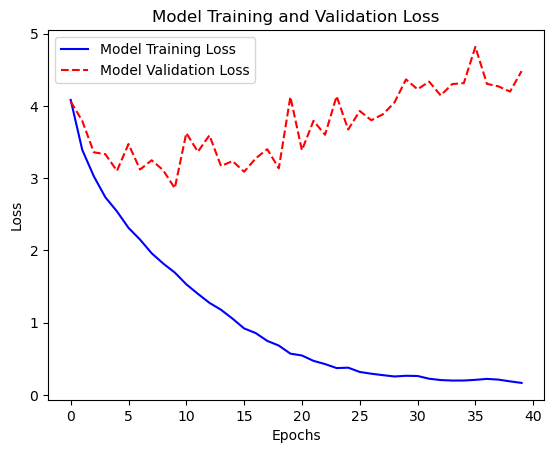

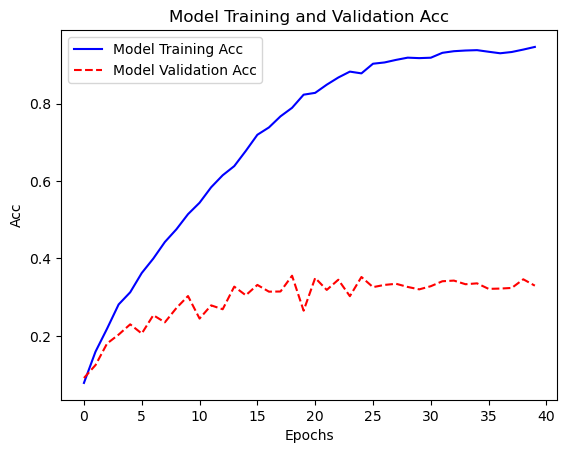

In [17]:
# 여기서 부터 시각화
# No Augmentation
Loss_Visualization(train_losses_None, val_losses_None)
Acc_Visualization(train_acc_list_None, val_acc_list_None)

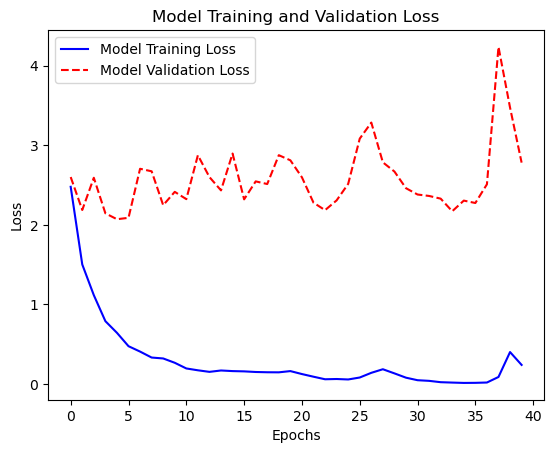

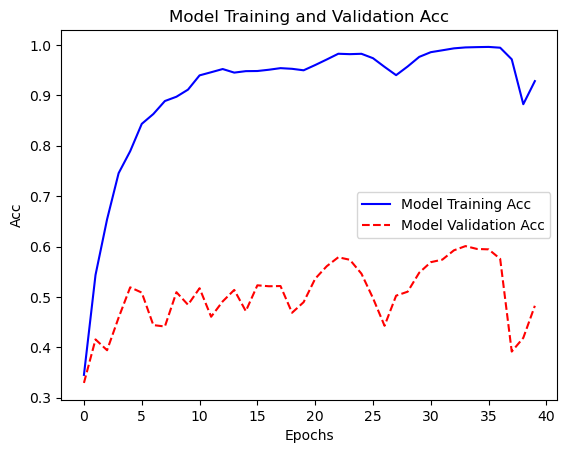

In [18]:
# Auagmentation
Loss_Visualization(train_losses_Aug, val_losses_Aug)
Acc_Visualization(train_acc_list_Aug, val_acc_list_Aug)

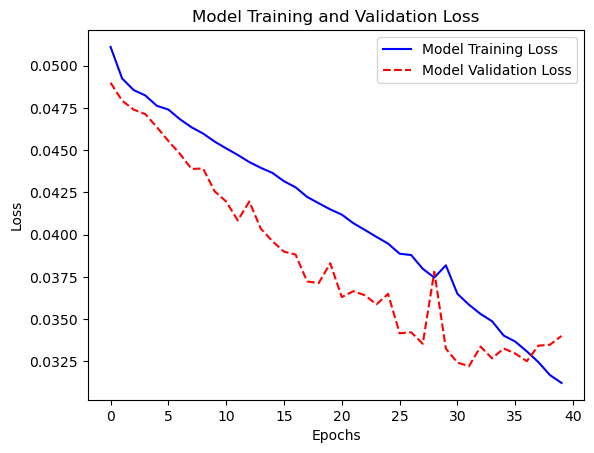

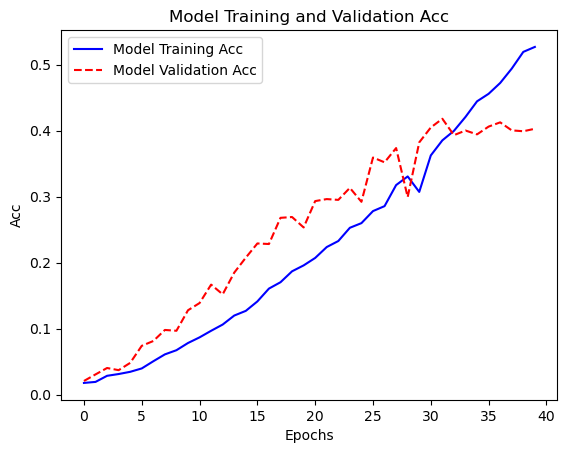

In [19]:
# Mixup
Loss_Visualization(train_losses_Cutmix, val_losses_Cutmix)
Acc_Visualization(train_acc_list_Cutmix, val_acc_list_Cutmix)

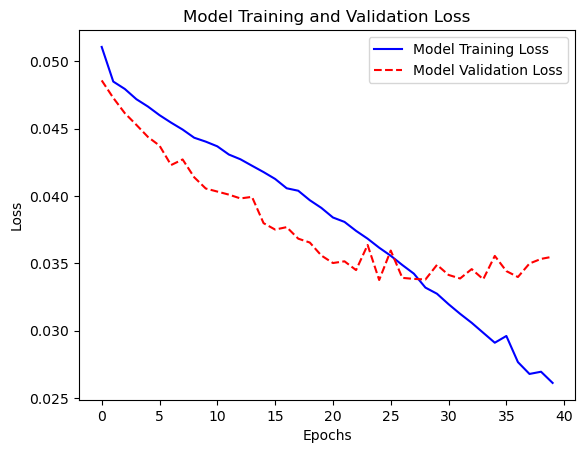

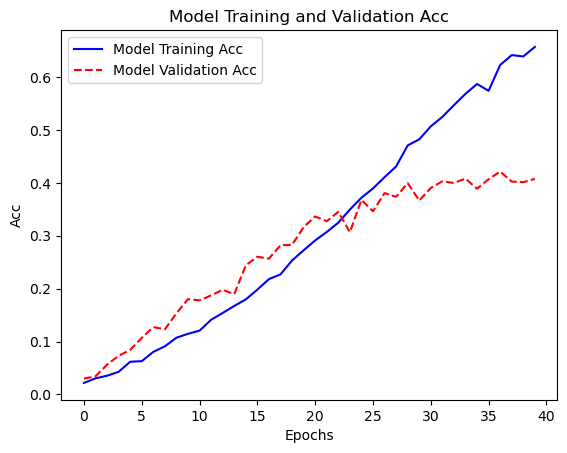

In [20]:
# CutMix
Loss_Visualization(train_losses_Mixup, val_losses_Mixup)
Acc_Visualization(train_acc_list_Mixup, val_acc_list_Mixup)

# 결과

모든 모델은 ResNet50을 기준으로 학습하였으며 weight는 IMAGENET1K_V1 를 사용하였습니다. 따라서, 모든 모델은 ImageNet을 기준으로 학습이 되어 있는 모델입니다. 여기에 전체적인 학습을 진행한다고 하였을 때 모델이 망가질 가능성이 큽니다. 하지만, 이러한 dataset의 성능 비교 시 baseline을 빠르게 구축할 수 있다는 장점이 있습니다. 4개의 각 모델들은 크기가 제한 시간 내에 학습시키기에 큰 모델이기에 30epoch, learning rate 0.001로 학습하였습니다. 이는 경향성을 보기에 충분한 수치로 보였습니다. 모든 판단의 기준은 loss를 기준으로 판단하였습니다.

1. No-augmentation
Augmentation을 하지 않았을 경우 unseem data에 대하여 모델이 일정 이상 정확도가 개선되지 못하고 0.3 정도의 accuracy로 수렴하는 것을 볼 수 있었습니다. 이는, 실제 상황에서의 noise가 예측을 방해하여 training에 비해 정확도가 낮아진 것을 확인할 수 있습니다. 또한, Augmentation을 하지 않았을 경우 overfitting의 경향은 18 epoch 근처에서 나타났습니다.

|Model|Best Training Accuracy|Best Validation Accuracy|
|-----|--------|--------|
|ResNet50|0.9193|0.3398|

2. Augmentation
Augmentation을 수행 한 이미지로 학습 할 경우 실제 상황에서의 noise에 대하여 robust한 모델을 구축할 수 있게 되었습니다. 그 결과로 unseem data에 대하여 0.6008이라는 정확도를 달성하였습니다. 하지만, 학습이 불안정하게 되는 경향이 있어서 빠른 결과를 보기 위해 높인 learning rate를 줄여서 불안정성일 줄일 필요가 있어 보였습니다. 수렴 속도는 이전보다 더 빠른 경향이 있었습니다. Augmentation을 수행했을 경우 overfitting의 경향은 6 epoch 근처에서 나타났으나, validation에서 정확도가 계속 증가하는 경향성을 보였습니다.

|Model|Best Training Accuracy|Best Validation Accuracy|
|-----|--------|--------|
|ResNet50_Aug|0.9959|0.6008|

3. Mixup
Mixup의 경우 이전 augmetation만 주거나 raw 이미지만 주었을 때 보다 매우 느린 속도로 수렴하였습니다. 이는 모델이 어려운 classification을 수행함에 따라 학습률이 느린 것 일수도 있습니다. 여기서 사용된 Loss는 BCE Loss 로 multi label classification 문제에 자주 사용되는 loss 입니다. 또한, 초반에 validation set에서 문제를 더 잘 맞추는 경향이 있는데, 이는 Mixup이 trainset에만 적용되어있기 때문에 상대적으로 validationset이 더 쉬운 task 이기 때문입니다. 하지만, 후반에서는 trainset의 학습을 계속 진행함에 따라 validationset 보다 정답율이 높아지게 되었습니다. 이 경우 overfitting의 경향성이 나오지는 않았으며 validation과 training loss의 경향성을 보았을 때 추가적인 훈련을 통해 성능이 개선될 수 있음을 시사하였습니다.

|Model|Best Training Accuracy|Best Validation Accuracy|
|-----|--------|--------|
|ResNet50_Mixup|0.6570|0.3996|

4. CutMix
Mixup과 같이 Cutmix가 trainset에만 적용되어있기 때문에 상대적으로 validationset을 초반에 잘 맞추는 경향이 있습니다. 하지만, Mixup보다 trainset에 대한 정확도가 빠르게 수렴하는 경향성이 있으며, 정확도 기준으로 조금 더 안정적인 경향성이 있습니다. 후반에 validation 기준 비슷하게 나오는 경향성이 있으나 overfitting의 경향성으로 보기는 어렵습니다. 따라서, CutMix또한 validation과 training loss의 경향성을 보았을 때 추가적인 학습이 필요하며 훈련을 통해성능이 개선될수 있음을 시사합니다

|Model|Best Training Accuracy|Best Validation Accuracy|
|-----|--------|--------|
|ResNet50_CutMix|0.5268|0.4125|


# 결론

각 dataset에 대하여 전부 다른 특징을 갖고 있는것이 보였습니다. 이는 전체적으로 하나의 augmentation의 의존해서 학습시킬 경우 언젠가는 그 한계의 부딛칠 수 있다는 것을 시사합니다. 따라서, 기본적인 augmentation을 통해 빠르게 학습하고, 후반에 CutMix나 Mixup을 통해 학습을 하는것이 제일 좋은 결과를 줄것으로 보여집니다. 이를 무작위로 섞어서 사용하는 방법도 적용할 수 있습니다. 이러한 dataset의 적절한 혼합이 기존의 모델의 한계를 추가적인 이미지 data 수집 없이 극복이 가능할 것이라는 것이 기대됩니다.
